In [65]:
import analysis
import importlib
importlib.reload(analysis)

import numpy as np
import matplotlib.pyplot as plt

# Density Field Slice

Computing ensemble mean field


100%|██████████| 111/111 [00:01<00:00, 76.44it/s]


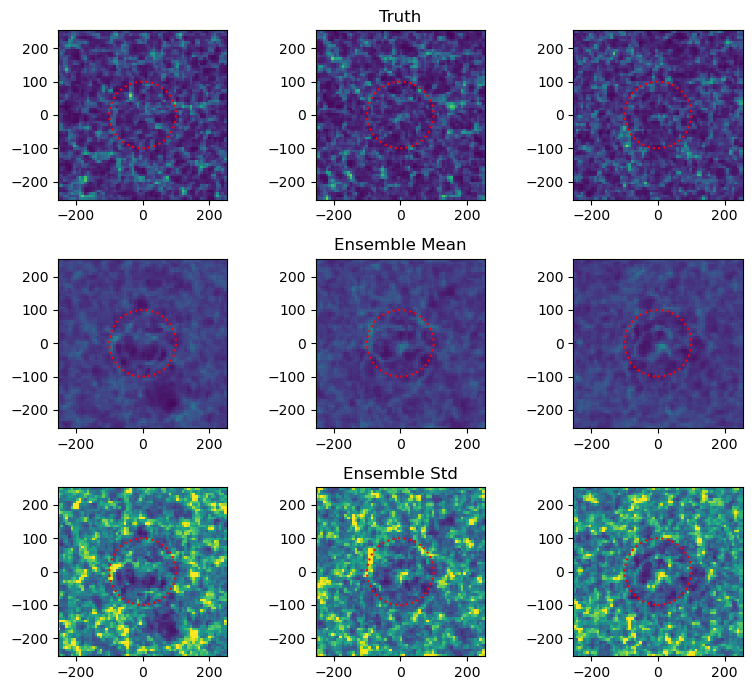

In [75]:
borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics'
ini_name = borg_dirname + '/ini_file.ini'
field_type = 'delta'
nframe = 100
iter_min = 1000
iter_max = 1767
cut_field = False

true_delta = analysis.crop_velmass_to_borg(ini_name, field_type)
if cut_field:
    true_delta, _ = analysis.crop_field(ini_name, true_delta)
borg_mean, borg_std = analysis.compute_ensemble_mean_field(ini_name, borg_dirname, nframe, iter_max, iter_min, cut_field=cut_field)

fig, axs = plt.subplots(3, 3, figsize=(8,7))

# Parameter for uncut box
Rmax = analysis.get_borg_Rmax(ini_name)
L0 = analysis.get_borg_Lbox(ini_name)
N0 = analysis.get_borg_N(ini_name)
corner0 = analysis.get_borg_corner(ini_name)

x = np.linspace(corner0, corner0+L0, N0)
if cut_field:
    m = np.abs(x) < Rmax
    x = x[m]

for i, field in enumerate([np.log10(2+true_delta), np.log10(2+borg_mean), borg_std]):
    if i == 0:
        vmin = field.min()
        vmax = field.max()
    N = field.shape[0]
    j = N//2
    axs[i,0].pcolor(x, x, field[j], vmin=vmin, vmax=vmax)
    axs[i,1].pcolor(x, x, field[:,j,:], vmin=vmin, vmax=vmax)
    axs[i,2].pcolor(x, x, field[:,:,j], vmin=vmin, vmax=vmax)
    for ax in axs[i,:]:
        circle = plt.Circle((0, 0), Rmax, color='red', fill=False, linestyle='dotted', lw=1.5)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.add_patch(circle)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    for ax in axs[i,:]:
        ax.set_aspect('equal')

axs[0,1].set_title('Truth')
axs[1,1].set_title('Ensemble Mean')
axs[2,1].set_title('Ensemble Std')

fig.tight_layout()

savename = f'../figs/field_slice_velmass_{field_type}'
if cut_field:
    savename += '_cropped'
fig.savefig(f'{savename}.png', bbox_inches='tight', facecolor='white')

# Power and Cross Spectra

BOXSIZE 198.41269841269843

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


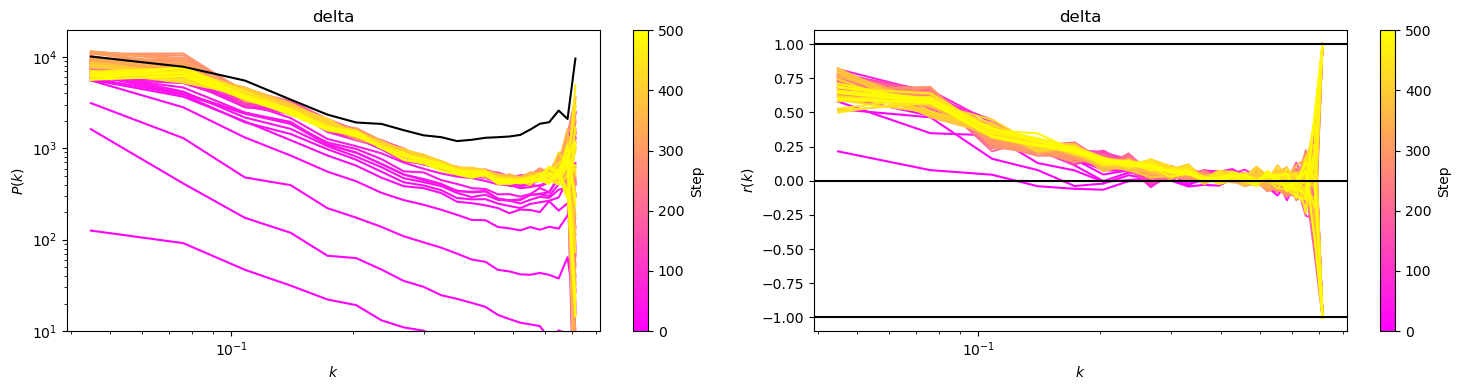

In [76]:
borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics'
ini_name = borg_dirname + '/ini_file.ini'
field_type = 'delta'
# field_type = 'ics'
nframe = 100
iter_min = 0
iter_max = 500 #1767
cut_field = True

k, Pk_true, all_pk, all_r = analysis.get_spectra(ini_name, borg_dirname, nframe, iter_max, iter_min, which_field=field_type, cut_field=cut_field, mock_type='velmass')
all_mcmc = analysis.get_mcmc_steps(borg_dirname, nframe, iter_max, iter_min=iter_min)

# Get axis range
if field_type == 'delta':
    ymin = 1e1
    ymax = None
else:
    ymin = None
    ymax = None

# Normalize the index for coloring
norm = plt.Normalize(all_mcmc[0], all_mcmc[-1])
cmap = plt.cm.spring  # Choose a colormap

fig, axs = plt.subplots(1, 2, figsize=(15,4))

# Plot Pk and r
for i in range(all_pk.shape[0]):
    axs[0].loglog(k, all_pk[i, :], color=cmap(norm(all_mcmc[i])))
    axs[1].semilogx(k, all_r[i, :], color=cmap(norm(all_mcmc[i])))
axs[0].loglog(k, Pk_true, color='k')
for i in [-1, 0, 1]:
    axs[1].axhline(i, color='k')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
for ax in axs:
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Step')
    ax.set_title(field_type)
    ax.set_xlabel(r'$k$')
axs[0].set_ylim(ymin, ymax)
axs[0].set_ylabel(r'$P(k)$')
axs[1].set_ylabel(r'$r(k)$')
fig.tight_layout()
savename = f'../figs/pk_velmass_{field_type}'
if cut_field:
    savename += '_cropped'
# fig.savefig(f'{savename}.png', bbox_inches='tight', facecolor='white')

# TO DO

* Looks like VELMASS ICs are after P(k) applied - extract white noise field